In [67]:
from collections import defaultdict
import json
from glob import glob
from typing import Tuple

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import exp
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns

from utils import dict_sum, as_series, as_dataframe, to_cumulative

mpl.rcParams['lines.linewidth'] = 2.5

# Base line variant distribution

In [68]:
def json_counts_to_dataframe() -> Tuple[pd.DataFrame, pd.DataFrame]:
    normal_counts = defaultdict(lambda: defaultdict(int))
    variant_counts = defaultdict(lambda: defaultdict(int))
    max_fragment_size = 1
    for json_file in glob('output/*.json'):
        with open(json_file) as file_object:
            fragments = json.load(file_object)
            for var in fragments['variants']:
                counts = var["fragment_size_counts"]
                normal_base = var["nucleotide_normal"]
                gene = var['gene']
                normal_counts[gene] = dict_sum(normal_counts[gene], counts[normal_base])
                for base in var['nucleotide_variants']:
                    variant_counts[gene] = dict_sum(variant_counts[gene], counts[base])
            max_fragment_size = max(max(normal_counts[gene].keys()), max(variant_counts[gene].keys()), max_fragment_size)

    normals = as_dataframe(normal_counts, max_fragment_size)
    variants = as_dataframe(variant_counts, max_fragment_size)
    return normals, variants

In [69]:
normals, variants = json_counts_to_dataframe()

In [71]:
normals.describe()

,ABL1,AKT1,AKT2,ALK,APC,AR,BRAF,BRCA1,BRCA2,CCND2,...,RET,RNF43,ROS1,SMAD4,SMO,STK11,TERT,TP53,TSC1,TSC2
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,...,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,15.809417,7.915919,3.873318,31.769058,45.142377,73.803812,89.312780,37.844170,108.975336,21.288117,...,48.397982,51.486547,82.987668,55.408072,23.587444,56.895740,42.043722,473.467489,6.651345,26.258969
std,45.555477,28.918957,11.923940,113.502401,134.614263,208.986890,261.907806,120.235092,340.395946,61.678022,...,157.860512,148.777566,275.350137,178.021359,78.223357,158.835702,149.998007,1345.819369,18.172653,95.637146
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,4.000000,6.000000,8.000000,1.000000,4.000000,1.000000,...,2.000000,6.000000,2.000000,2.000000,0.000000,3.000000,2.000000,56.000000,1.000000,0.000000
75%,9.000000,2.000000,2.000000,8.000000,23.000000,42.000000,47.250000,18.000000,56.000000,11.000000,...,19.250000,26.000000,34.250000,24.000000,8.000000,35.000000,12.000000,248.250000,4.000000,8.250000
max,383.000000,251.000000,110.000000,914.000000,973.000000,1625.000000,1931.000000,982.000000,2662.000000,512.000000,...,1240.000000,1204.000000,2233.000000,1312.000000,648.000000,1199.000000,1393.000000,10038.000000,148.000000,774.000000


In [4]:
def kolmogorov_smirnov(normal_counts, variant_counts):
    m = sum(normal_counts)
    n = sum(variant_counts)
    D = max(to_cumulative(normal_counts) - to_cumulative(variant_counts))
    r = (n + m)/(n*m)
    alpha = 2 * exp(- 2 * D**2 /r) 
    return alpha

In [5]:
def plot_distribution_comparison(normal_counts, variant_counts, filename_suffix = None):
    normal_distribution = normal_counts / sum(normal_counts)
    normal_cumul = normal_distribution.cumsum()
    variant_distribution = variant_counts / sum(variant_counts)
    variant_cumul = variant_distribution.cumsum()
    
    fragment_window = [50, 500]
    
    normal_distribution.plot(label='normal')
    variant_distribution.plot(label='variant')
    plt.legend(frameon=False)
    plt.xlim(fragment_window)
    p = kolmogorov_smirnov(normal_counts, variant_counts)
    plt.annotate('$p$ = {:.1E}'.format(p), xy=(300, 0.015))
    plt.xlabel('Fragment size (bp)')
    plt.ylabel('Frequency')
    if filename_suffix is not None:
        plt.savefig(f'figs/fragment_size_distribution_{filename_suffix}.png')
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(normal_cumul, label='normal')
    plt.plot(variant_cumul, label='variant')
    plt.ylabel('Cumulative distribution')
    plt.xlabel('Fragment size (bp)')
    plt.xlim(fragment_window)
    
    plt.subplot(1, 2, 2)
    plt.plot(normal_cumul-variant_cumul)
    plt.xlabel('Fragment size (bp)')
    plt.ylabel('Kolmogorov-Smirnov distance')
    plt.xlabel('Fragment size (bp)')
    plt.xlim(fragment_window)
    plt.tight_layout()
    if filename_suffix is not None:
        plt.savefig(f'figs/fragment_size_distribution_difference_{filename_suffix}.png')

In [78]:
def plot_distribution_with_peaks(seq, label=None):
    n = 5
    peak_constaints = {'width': 15, 'distance': 50, 'rel_height': 0.85}
    seq /= sum(seq)
    peaks, properties = find_peaks(seq.rolling(n).mean(), **peak_constaints)
    print(peaks)
    print(properties['widths'])
    
    fragment_window = [50, 500]
    seq.rolling(n).mean().plot(label=label, zorder=0)
    plt.plot(peaks, seq[peaks], 'o', zorder=1)
    plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
               xmax=properties["right_ips"], color = "C1", zorder=2)
    plt.xlim(fragment_window)

# Everything together


[167 314 477 633]
[61.9437081  93.31292623 82.03063725 16.97202797]
[167 303 433 711]
[69.2945536  72.29953689 36.30457009 48.20001833]


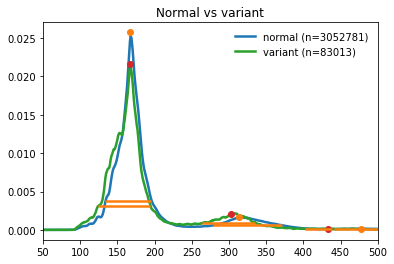

In [92]:
plt.title('Normal vs variant')
plot_distribution_with_peaks(normals.sum(axis=1), label=f'normal (n={normals.sum().sum()})')
plot_distribution_with_peaks(variants.sum(axis=1), label=f'variant (n={int(variants.sum().sum())})')
plt.legend(frameon=False)
plt.savefig('figs/normal_variant.png')

[167 314 477 633]
[61.9437081  93.31292623 82.03063725 16.97202797]
[166 310]
[77.8        16.66666667]


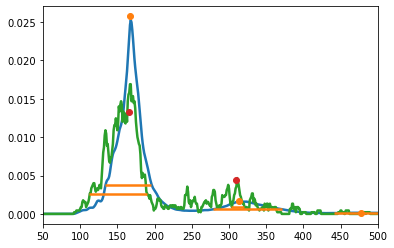

In [80]:
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['ROS1'])

[167 314 477 633]
[61.9437081  93.31292623 82.03063725 16.97202797]
[164 300 357 448 530]
[69.15  88.35  15.925 70.1   16.1  ]


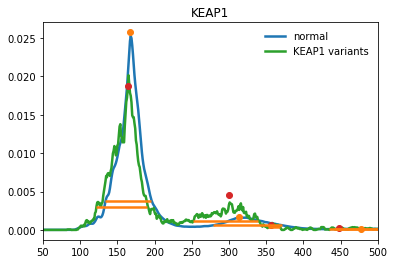

In [81]:
plt.title('KEAP1')
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['KEAP1'], label='KEAP1 variants')
plt.legend(frameon=False)
plt.savefig('figs/keap1.png')

[167 314 477 633]
[61.9437081  93.31292623 82.03063725 16.97202797]
[152 311 379]
[77.93303571 96.20833333 18.65      ]


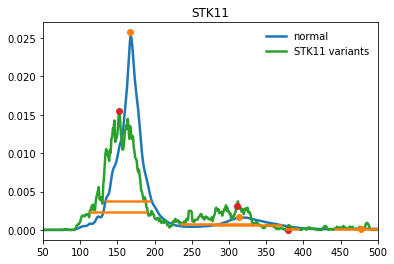

In [82]:
plt.title('STK11')
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['STK11'], label='STK11 variants')
plt.legend(frameon=False)
plt.savefig('figs/stk11.png')

[167 314 477 633]
[61.9437081  93.31292623 82.03063725 16.97202797]
[167 299 421 489 555 643]
[ 62.54277133 105.49714286  15.65714286  44.37142857  35.16666667
  30.65      ]


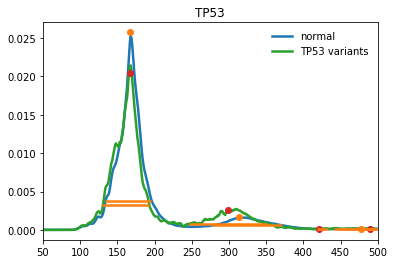

In [83]:
plt.title('TP53')
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['TP53'], label='TP53 variants')
plt.legend(frameon=False)
plt.savefig('figs/tp53.png')

In [40]:
def compare_peak_shifts(variant_distribution, reference_distribution):
    """
    Calculate the peak position and width for each gene distribution, and compare to reference distributions.
    
    Focus on distributions that are statistically significant.
    """
    n = 5  # Number of base pair smoothing.
    peak_constaints = {'width': 15, 'distance': 80, 'rel_height': 0.85}
    ref_peaks, ref_properties = find_peaks(reference_distribution.rolling(n).mean(), **peak_constaints)
    
    def peak_shift(sequence, num_peaks=2):
        """ Calculate shift and broadening for given sequence. """
        peaks, props = find_peaks(sequence.rolling(n).mean(), **peak_constaints)
        max_peaks = min(num_peaks, len(peaks), len(ref_peaks))
       
        s1 = pd.Series({
            f'{peak_number+1}_shift': peaks[peak_number] - ref_peaks[peak_number]
            for peak_number in range(max_peaks)
        })
        print(s1.index)
        s2 = pd.Series({
            f'{peak_number+1}_broadening': props['widths'][peak_number] - ref_properties['widths'][peak_number]
            for peak_number in range(max_peaks)
        })
        return pd.concat([s1,s2])

    # Filter columns on statistical significance.
    significant_columns = tuple(
        c 
        for c in variant_distribution.columns 
        if kolmogorov_smirnov(reference_distribution, variant_distribution[c]) < 0.05
    )
    # Calculate shift for each gene.
    data_frame = pd.DataFrame(columns=significant_columns)
    for c in significant_columns:
        print(c)
        data_frame[c] = peak_shift(variant_distribution[c])
    return data_frame


In [41]:
df = compare_peak_shifts(variants, normals.sum(axis=1)).T

ABL1
Index(['1_shift', '2_shift'], dtype='object')
APC
Index(['1_shift', '2_shift'], dtype='object')
AR
Index(['1_shift', '2_shift'], dtype='object')
BRAF
Index(['1_shift', '2_shift'], dtype='object')
CDK4
Index(['1_shift', '2_shift'], dtype='object')
CDKN2A
Index(['1_shift', '2_shift'], dtype='object')
CTNNB1
Index(['1_shift', '2_shift'], dtype='object')
EGFR
Index(['1_shift', '2_shift'], dtype='object')
FLT1
Index(['1_shift', '2_shift'], dtype='object')
IDH1
Index(['1_shift', '2_shift'], dtype='object')
KRAS
Index(['1_shift', '2_shift'], dtype='object')
MSH2
Index(['1_shift', '2_shift'], dtype='object')
NFE2L2
Index(['1_shift', '2_shift'], dtype='object')
PDGFRB
Index(['1_shift', '2_shift'], dtype='object')
PMS2
Index(['1_shift', '2_shift'], dtype='object')
RNF43
Index(['1_shift', '2_shift'], dtype='object')
SMO
Index(['1_shift', '2_shift'], dtype='object')
TERT
Index(['1_shift', '2_shift'], dtype='object')
TP53
Index(['1_shift', '2_shift'], dtype='object')


In [42]:
def plot_peak(df, peak_number: int):
#     plt.figure(figsize=(4,3))
    plt.title(f'Peak {peak_number}')
    x_column = f'{peak_number}_shift'
    y_column = f'{peak_number}_broadening'
    xlim = (min(df[x_column])-2, max(df[x_column])+2)
    ylim = (min(df[y_column])-2, max(df[y_column])+2)
    plt.plot([0, 0], ylim, '-k', zorder=1, alpha=0.5)
    plt.plot(xlim, [0, 0], '-k', zorder=1, alpha=0.5)

    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.scatterplot(
        x=x_column, 
        y=y_column, 
        hue=df.index,
        data=df,
        zorder=2,
    )
    plt.ylabel('Broadening (bp)')
    plt.xlabel('Shift (bp)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

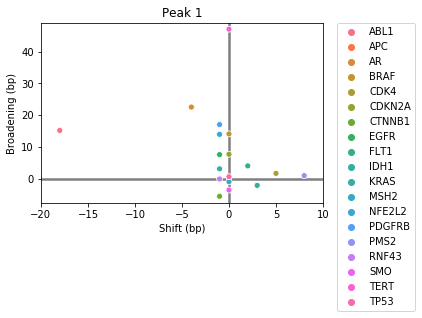

In [43]:
plot_peak(df, peak_number=1)
plt.savefig('figs/peak1.png', bbox_inches='tight')

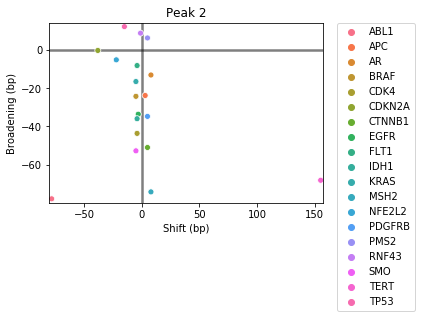

In [44]:
plot_peak(df, peak_number=2)
plt.savefig('figs/peak2.png', bbox_inches='tight')

[167 309]
[32.76172565 45.21388276]


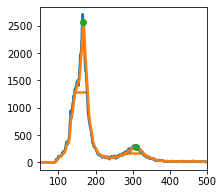

In [17]:
plt.figure(figsize=(3, 3))
from scipy.signal import find_peaks

seq = variants.sum(axis=1)
n = 5
peaks, properties = find_peaks(seq.rolling(n).mean(), width=15, distance=100)
print(peaks)
print(properties['widths'])
seq.plot()
seq.rolling(n).mean().plot()
fragment_window = [50, 500]
plt.xlim(fragment_window)
plt.plot(peaks, seq[peaks], 'o')
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

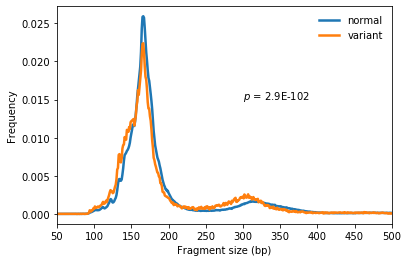

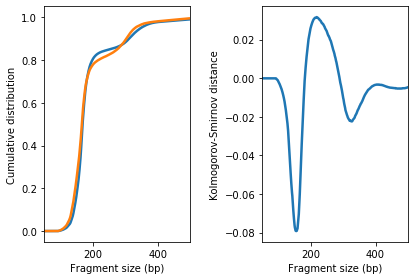

In [18]:
plot_distribution_comparison(normals.sum(axis=1), variants.sum(axis=1), filename_suffix='all')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


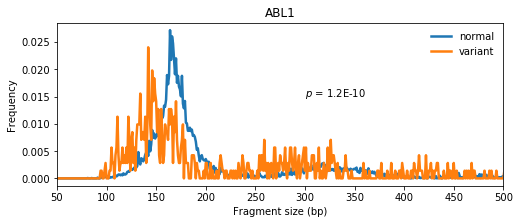

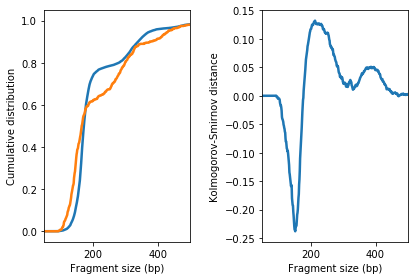

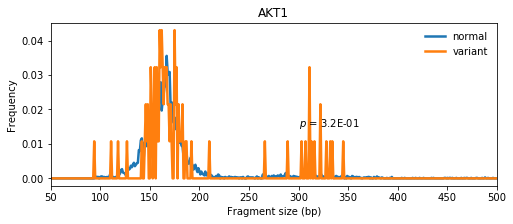

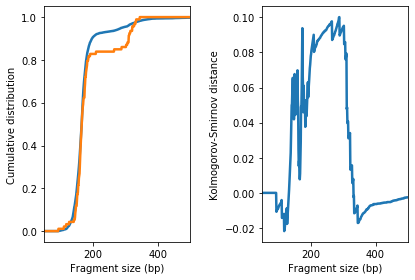

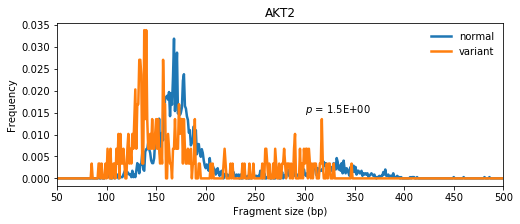

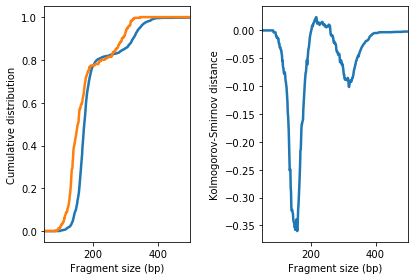

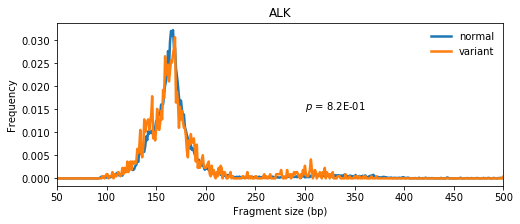

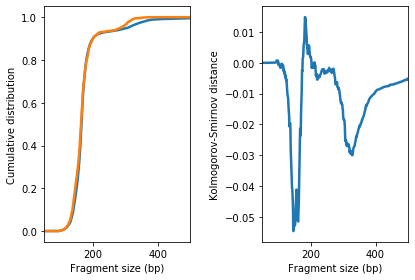

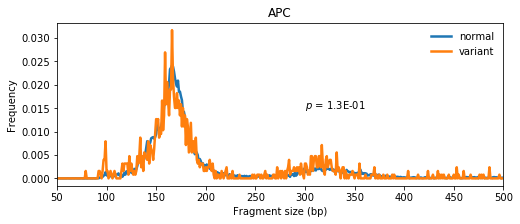

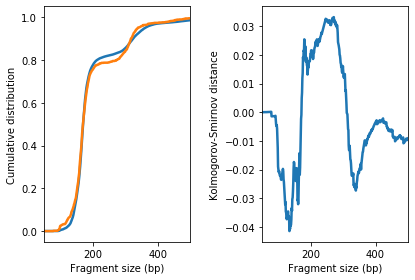

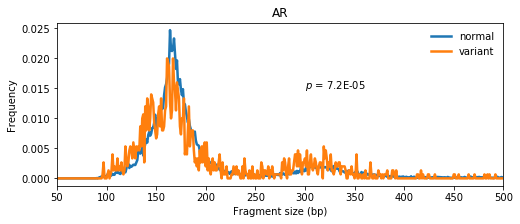

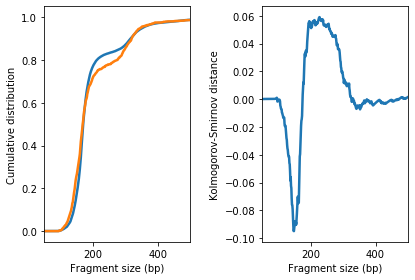

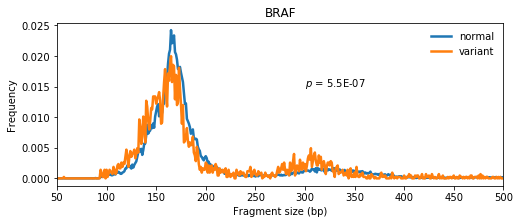

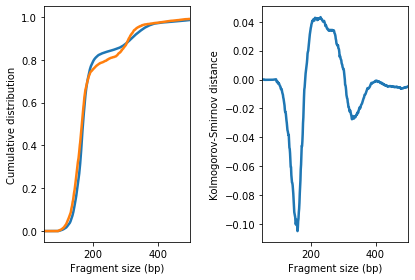

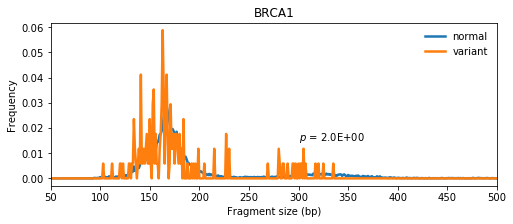

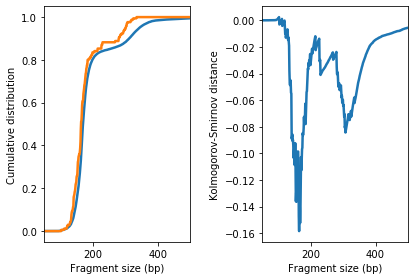

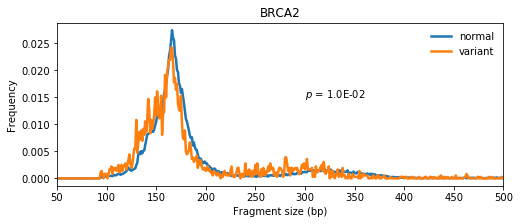

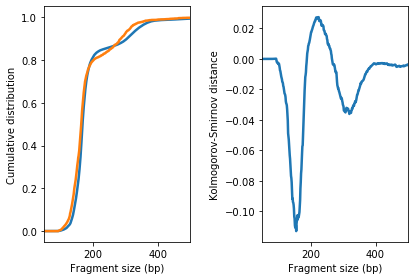

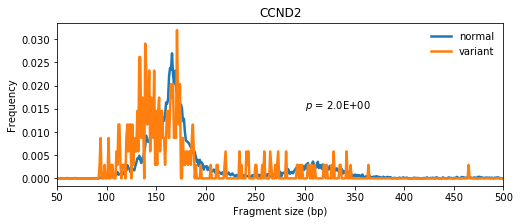

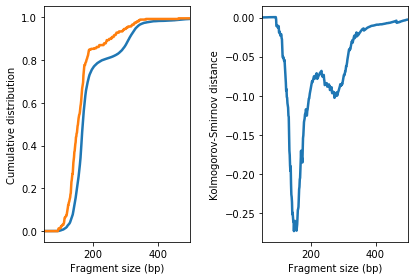

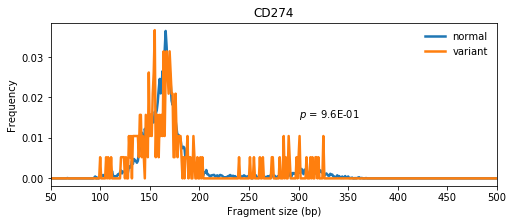

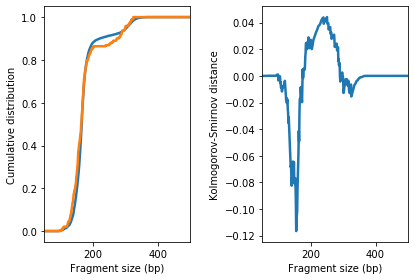

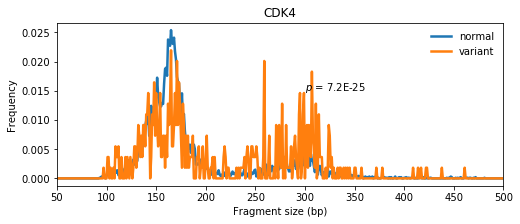

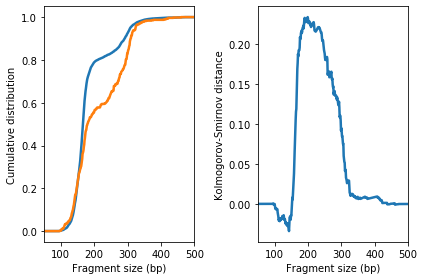

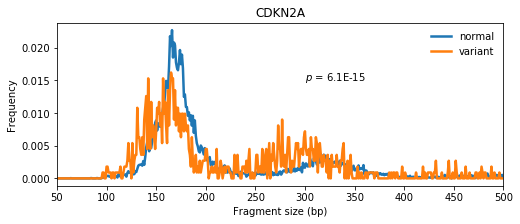

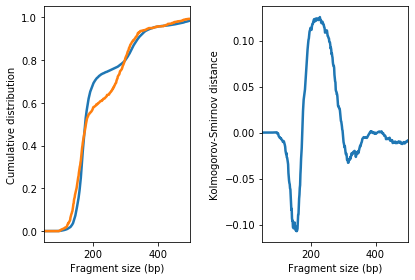

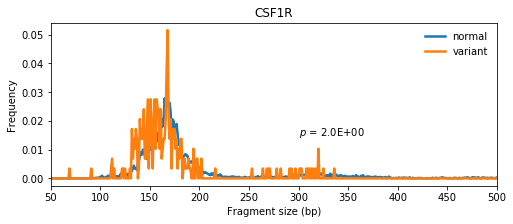

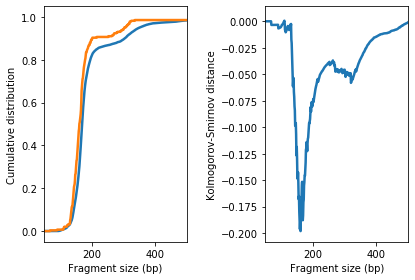

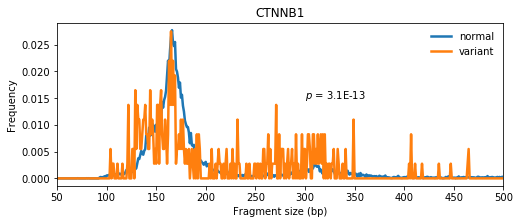

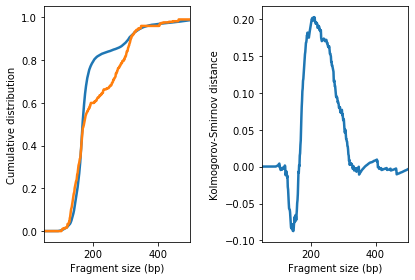

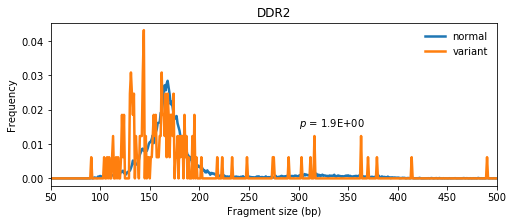

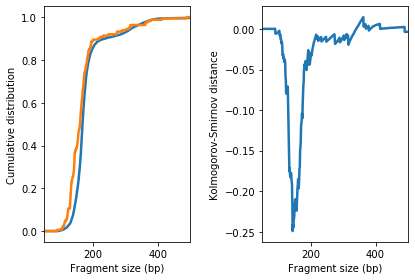

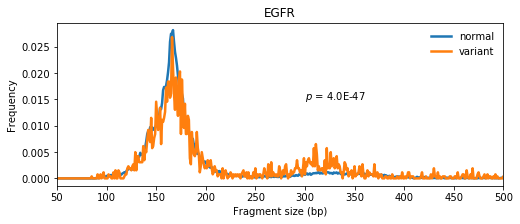

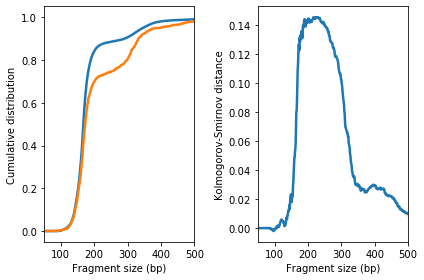

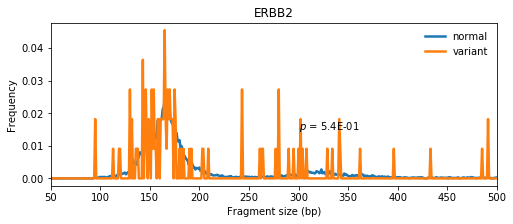

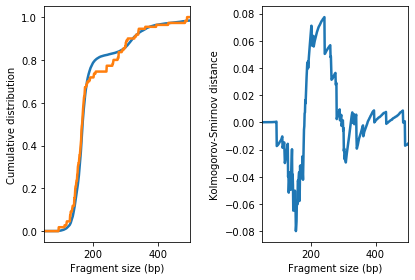

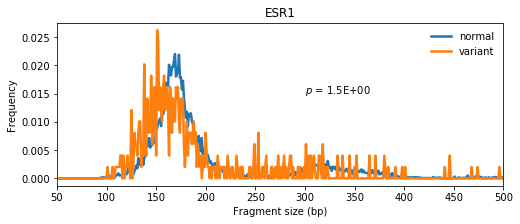

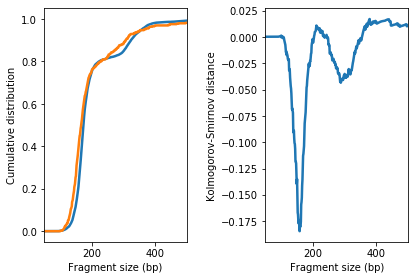

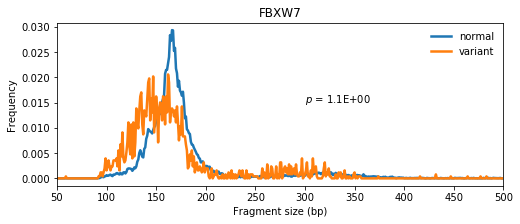

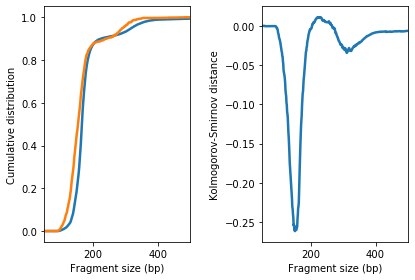

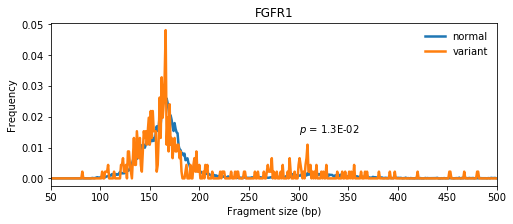

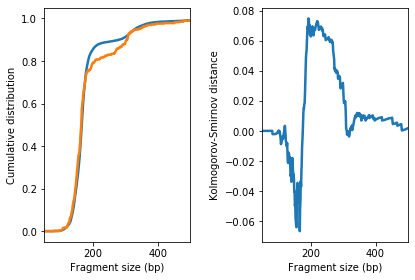

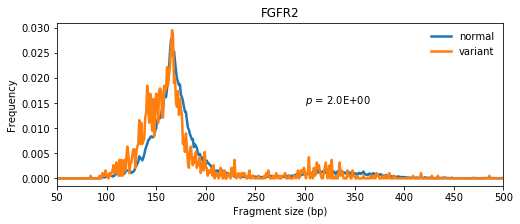

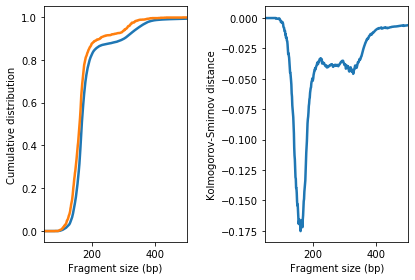

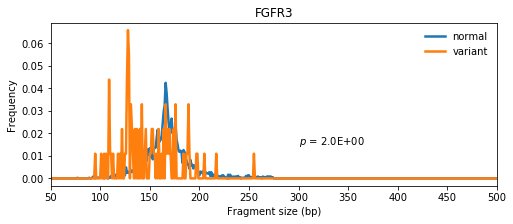

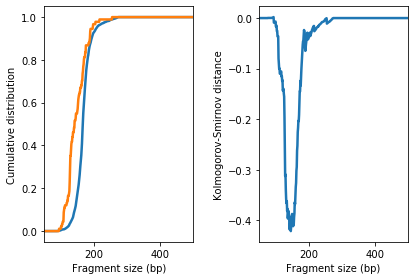

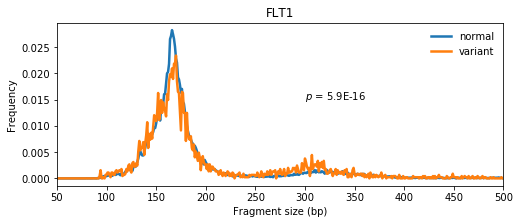

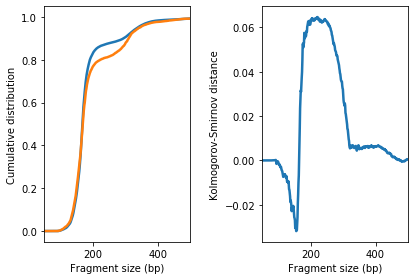

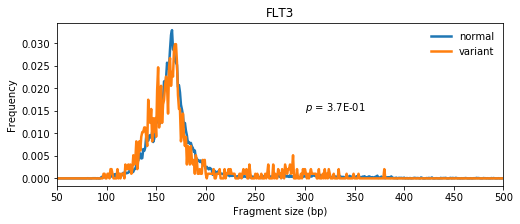

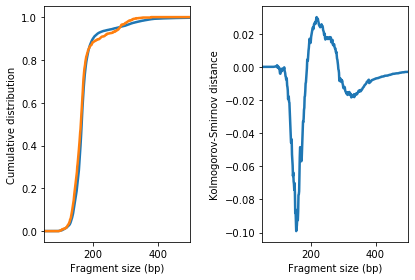

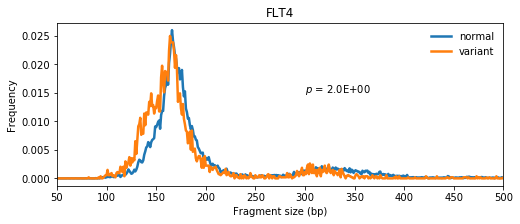

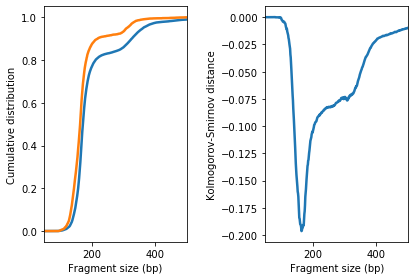

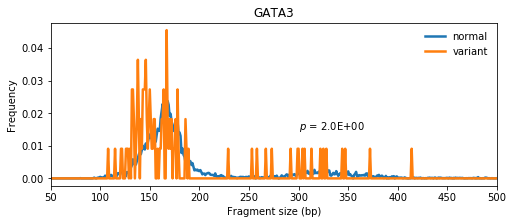

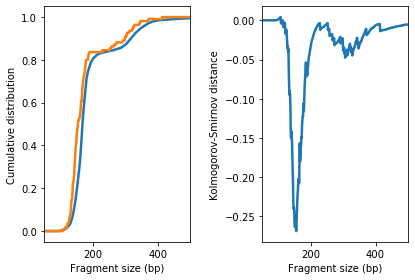

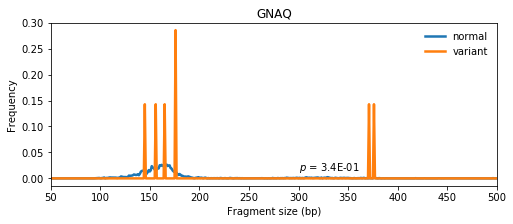

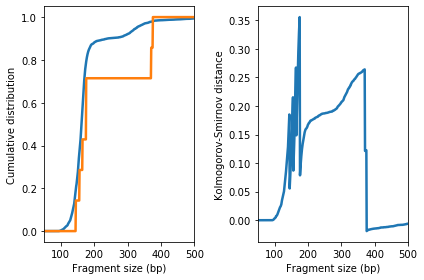

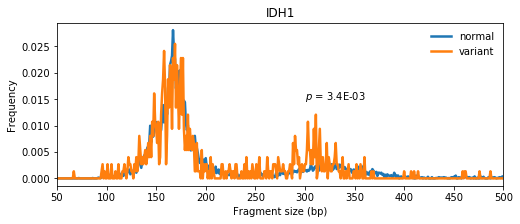

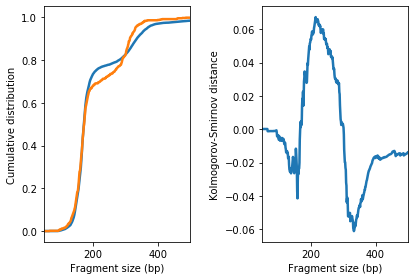

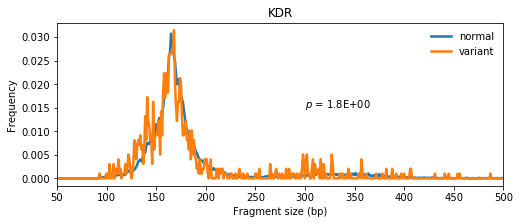

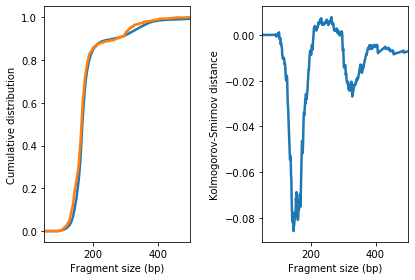

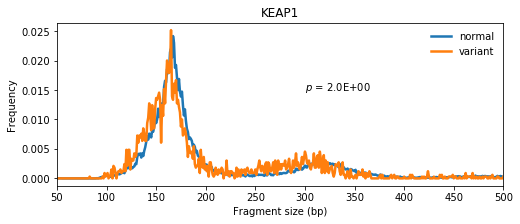

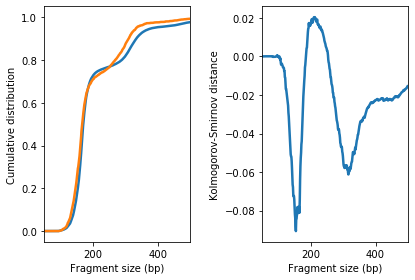

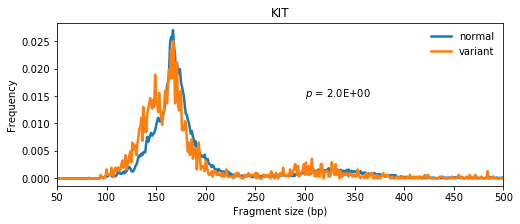

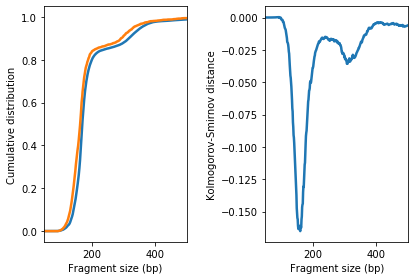

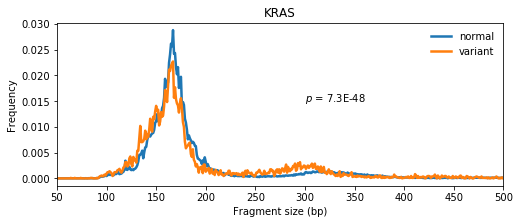

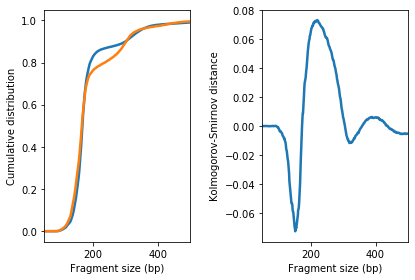

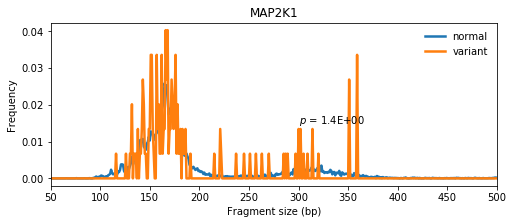

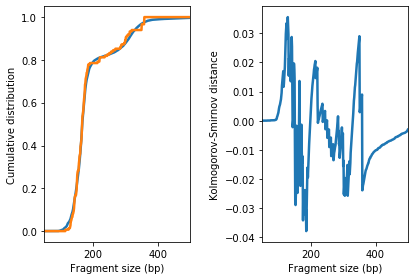

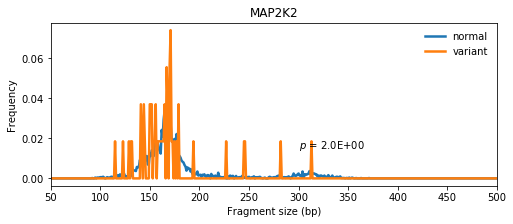

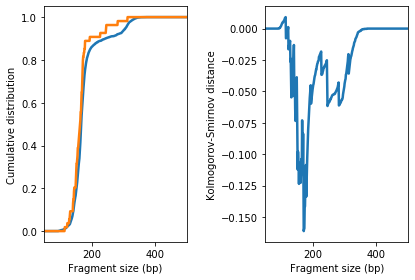

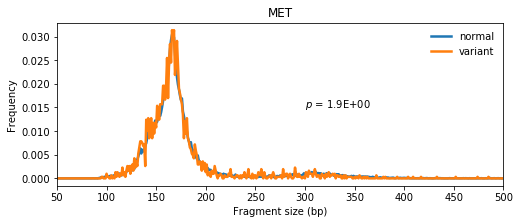

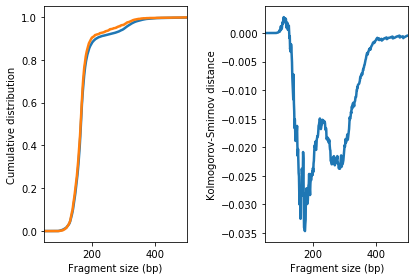

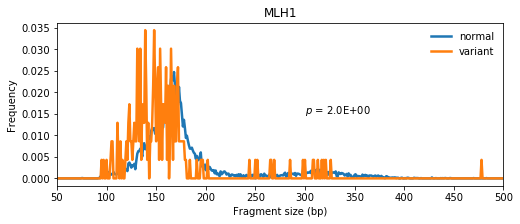

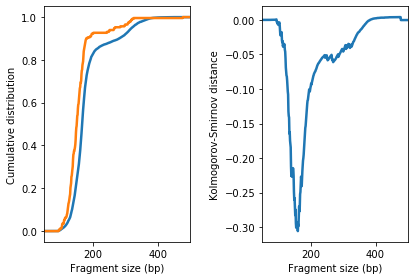

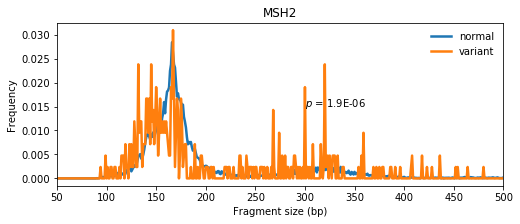

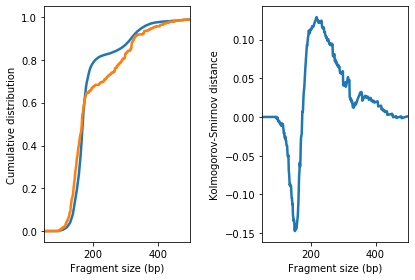

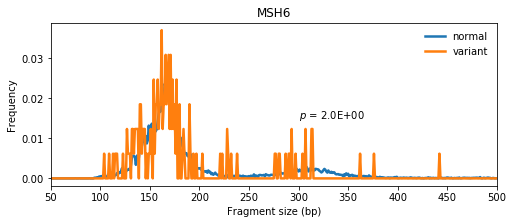

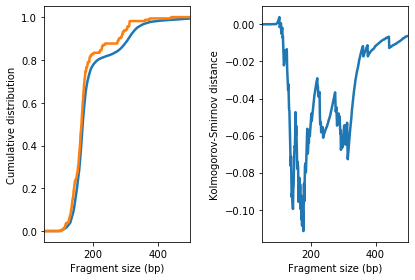

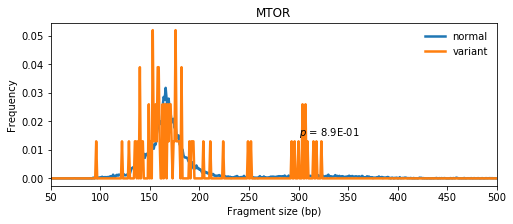

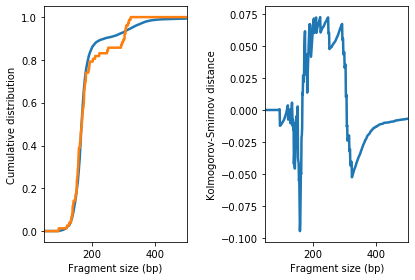

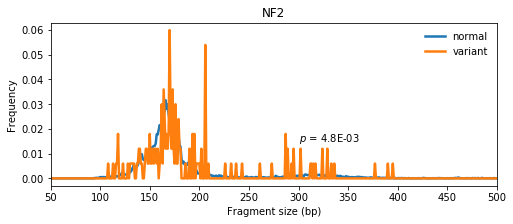

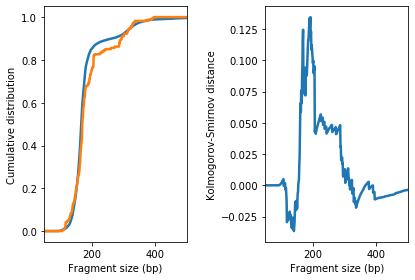

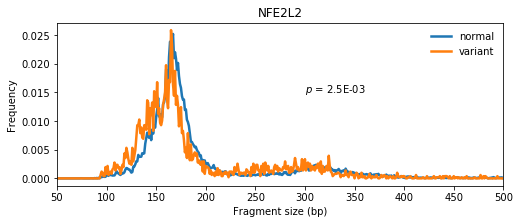

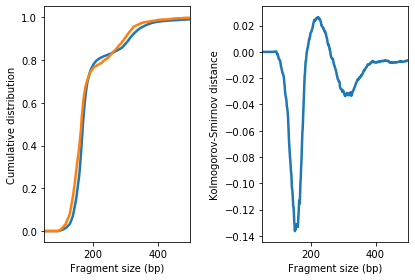

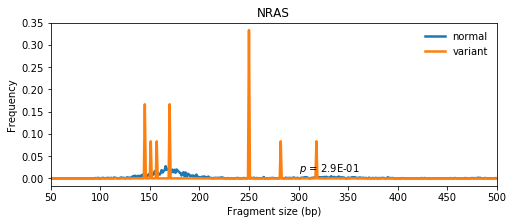

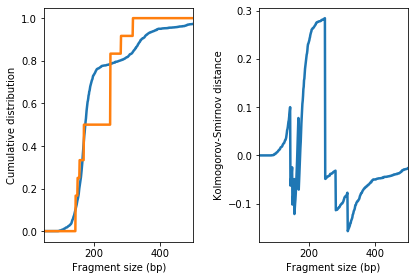

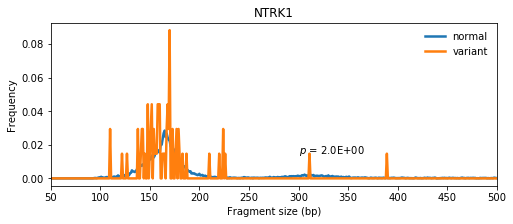

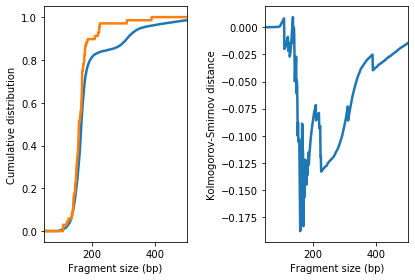

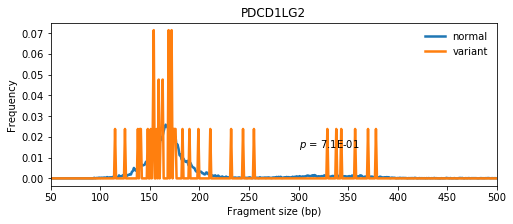

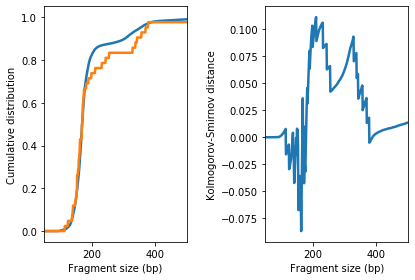

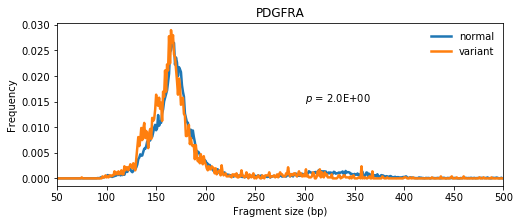

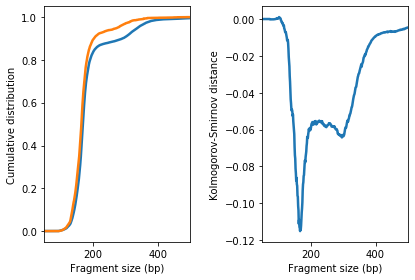

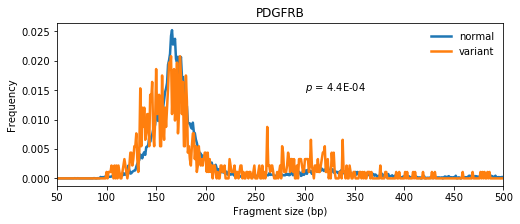

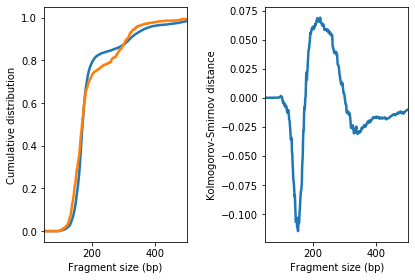

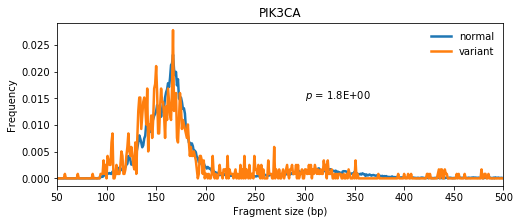

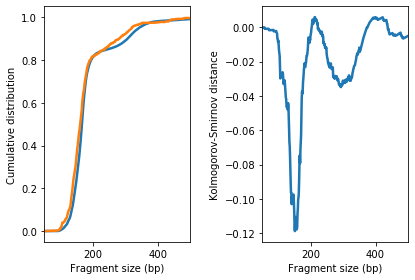

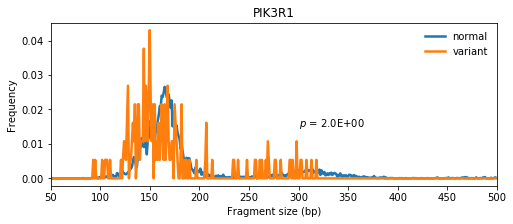

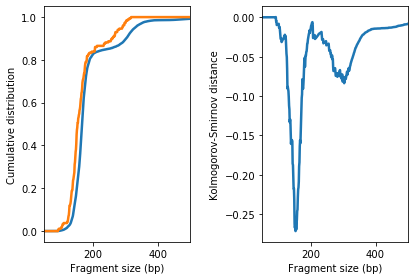

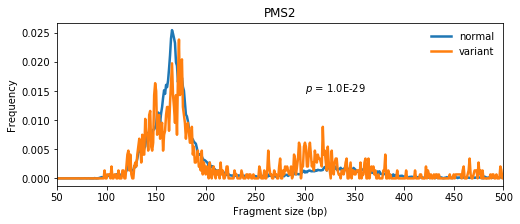

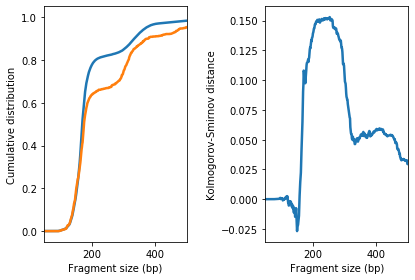

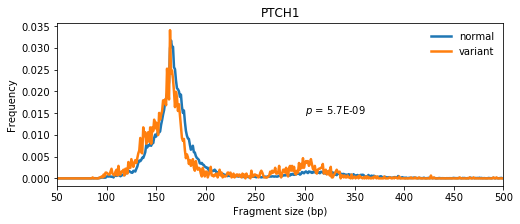

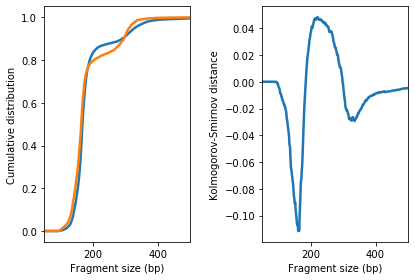

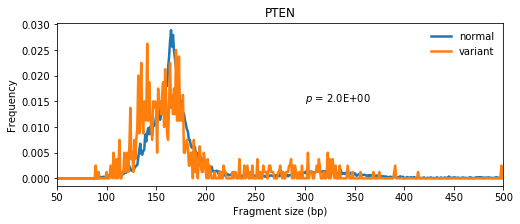

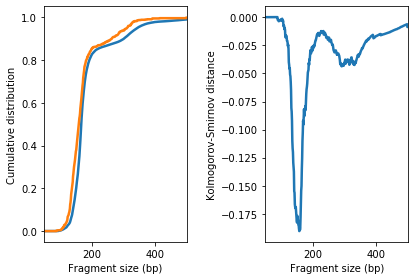

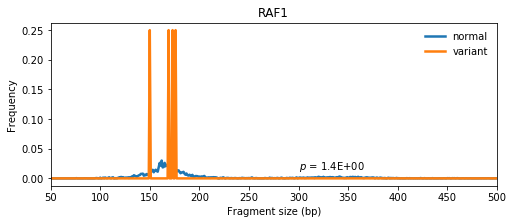

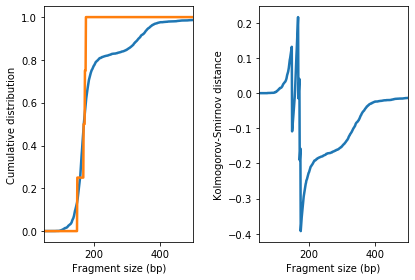

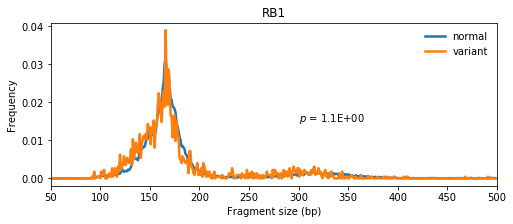

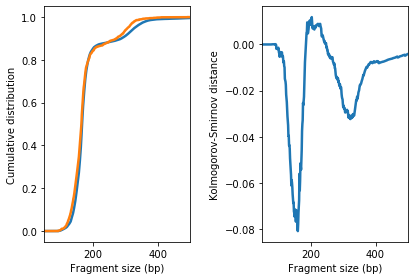

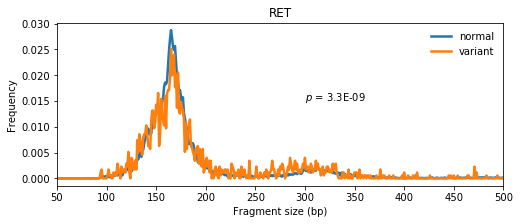

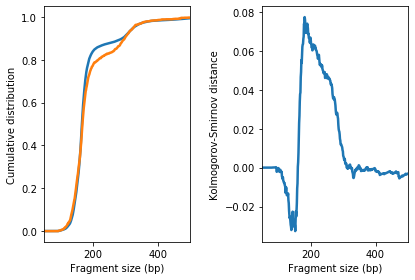

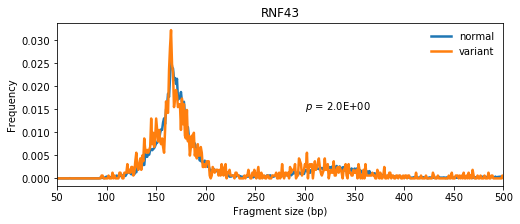

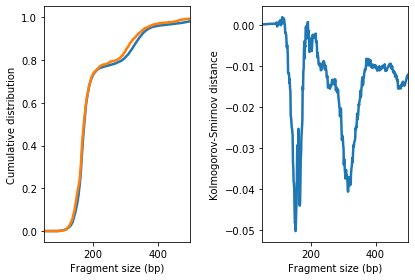

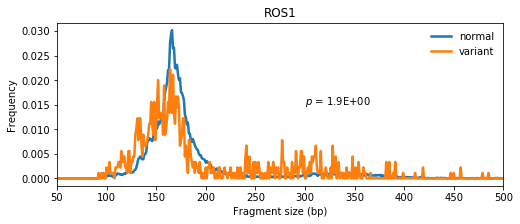

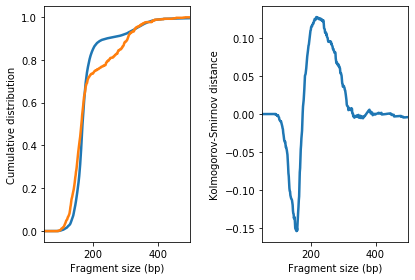

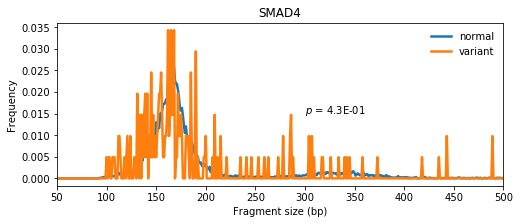

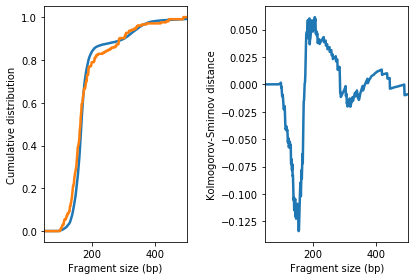

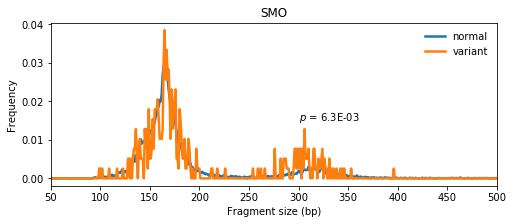

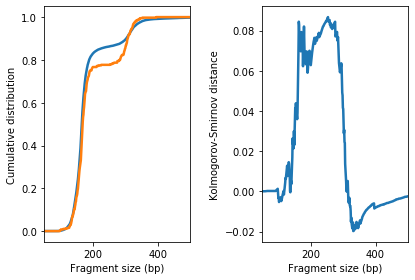

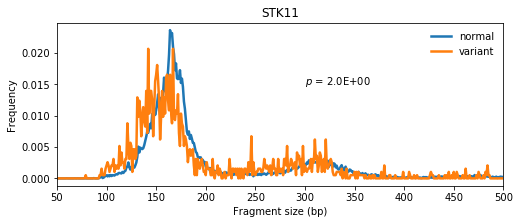

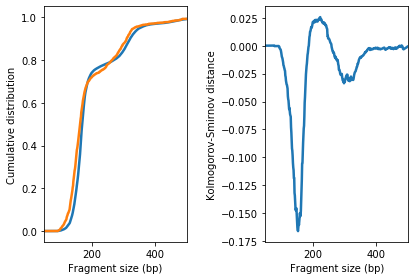

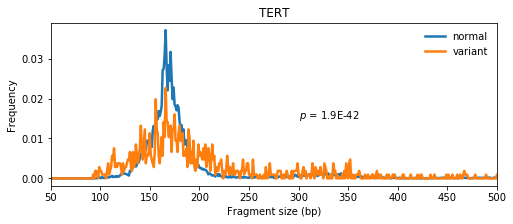

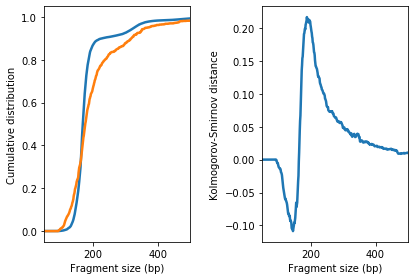

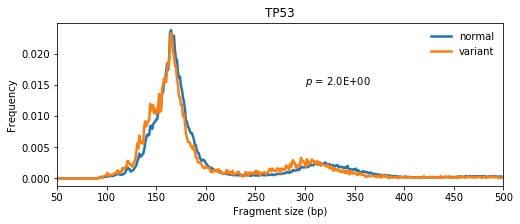

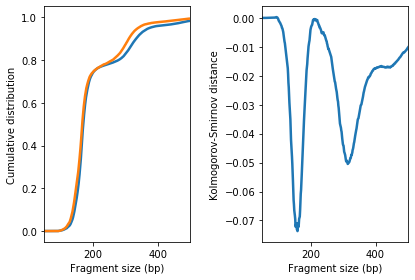

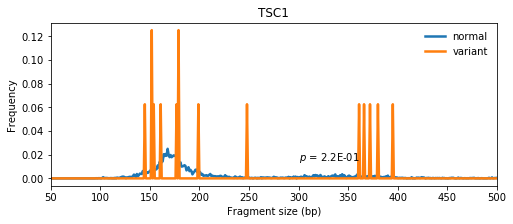

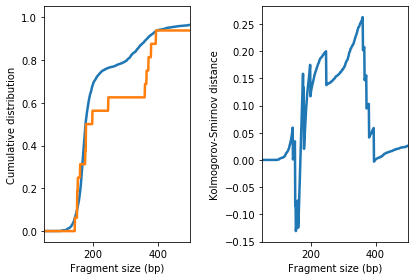

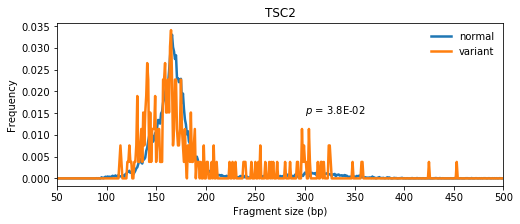

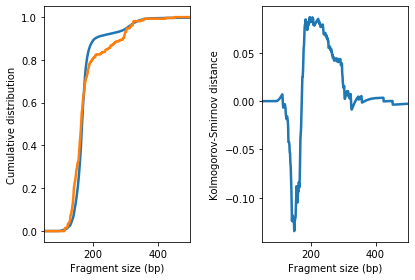

In [19]:
for gene in normals.columns:
    f = plt.figure(figsize=(8,3))
    plt.title(gene)
    plot_distribution_comparison(normals[gene], variants[gene])

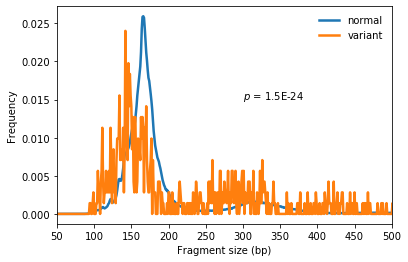

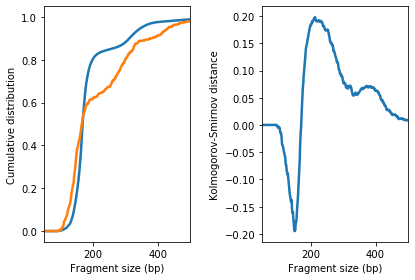

In [20]:
plot_distribution_comparison(normals.sum(axis=1), variants['ABL1'], filename_suffix='EGFR')

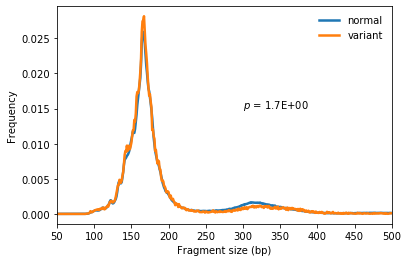

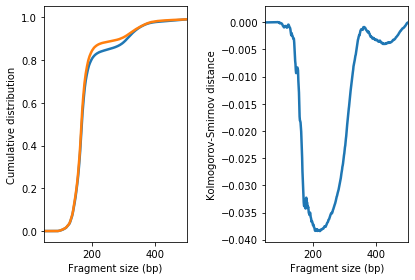

In [21]:
plot_distribution_comparison(normals.sum(axis=1), normals['EGFR'], filename_suffix='EGFR')

In [47]:
# Check that all normal genes are not significantly different.
significant_columns = tuple(
    c 
    for c in normals.columns 
    if kolmogorov_smirnov(normals.sum(axis=1), normals[c]) < 0.05/len(normals.columns)
)
significant_columns

('ABL1',
 'AKT2',
 'APC',
 'AR',
 'BRAF',
 'BRCA1',
 'CCND2',
 'CDK4',
 'CDKN2A',
 'CSF1R',
 'CTNNB1',
 'ERBB2',
 'ESR1',
 'FGFR2',
 'FLT4',
 'IDH1',
 'KDR',
 'KEAP1',
 'KIT',
 'MAP2K1',
 'MSH2',
 'MSH6',
 'NFE2L2',
 'NRAS',
 'NTRK1',
 'PDCD1LG2',
 'PDGFRA',
 'PDGFRB',
 'PMS2',
 'PTCH1',
 'RAF1',
 'RNF43',
 'ROS1',
 'STK11',
 'TERT',
 'TP53',
 'TSC1',
 'TSC2')

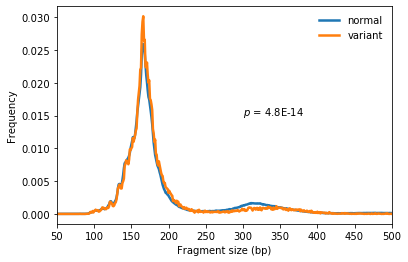

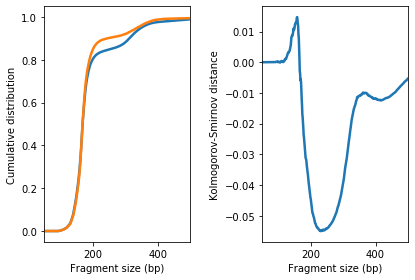

In [73]:
plot_distribution_comparison(normals.sum(axis=1), normals['ROS1'])